<a href="https://colab.research.google.com/github/gauthiermartin/pytorch-deep-learning-course/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets

We've used some datasets with PyTorch before.

But how to get your own data into PyTorch

One of the ways to do so is via : custom datasets.

## Domain libraries

Depending on what you're worjing on (vision, text, audio, ...) look for existing dataloader in each of those domain libraries to base your implementation on it

**Resources:**
* Book version of the course material for chapter 6 - https://www.learnpytorch.io/04_pytorch_custom_datasets/

* Ground truth version of the notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb


In [1]:
import torch
from torch import nn

device = "gpu" if torch.cuda.is_available() else "cpu"

In [2]:
device

'gpu'

In [3]:
!nvidia-smi

Fri Sep  1 11:51:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Get Data

Our dataset is a subset of the food101 dataset, which starts with 101 classes ours will starte with only 3 classes of food and 10% of images per classes (~ 75 training, 25 testing)

Why are we doing this ?  

When starting out ML Projects, it's important to try thing from a small subset of data to speed up experiments

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exist, skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak and sushi data")
    f.write(request.content)

  # Unzip
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak sushi data")
    zip_ref.extractall(image_path)



data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak sushi data


 ## 2. Becoming one with the data (data preparation and data exploration)


In [5]:
import os

def walk_through_dir(dir_path):
  """Walks through dir path returning it's contents."""

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path  / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to
1. Get all of the image paths
2. Pick a random image using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with Python PIL
5. Show the image an print metadata

Random image path:data/pizza_steak_sushi/test/sushi/1230335.jpg
Image class:sushi
Image height: 384
Image width: 512


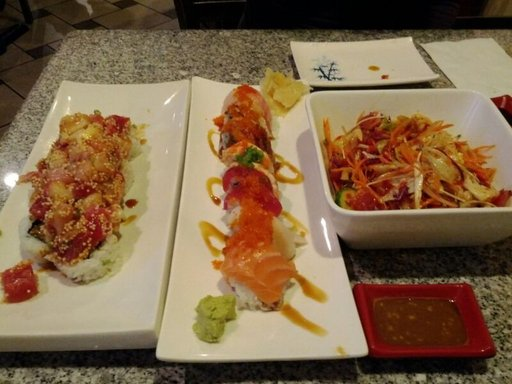

In [8]:
import random
from PIL import Image

# set seed
random.seed(42)

# 1. Get all the images paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class from the path name (the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open up the image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path:{random_image_path}")
print(f"Image class:{image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 383.5, -0.5)

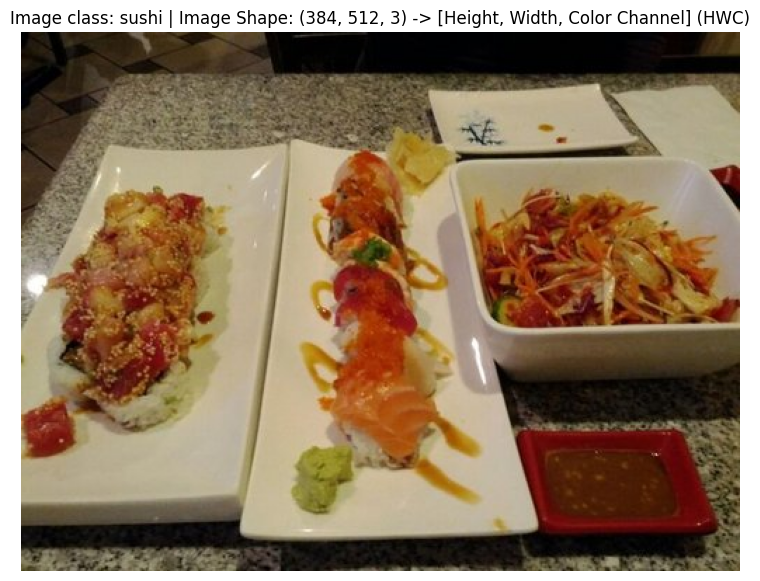

In [9]:
import numpy as np
import matplotlib.pyplot as plt

img_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image Shape: {img_array.shape} -> [Height, Width, Color Channel] (HWC)")
plt.axis(False)


In [10]:
img_array

array([[[  0,   3,   3],
        [  0,   6,   6],
        [  3,   5,   4],
        ...,
        [ 76,  53,  21],
        [ 81,  58,  26],
        [ 79,  56,  24]],

       [[  0,   2,   2],
        [  0,   3,   3],
        [  0,   2,   1],
        ...,
        [ 79,  56,  24],
        [ 84,  61,  29],
        [ 82,  59,  27]],

       [[  0,   2,   2],
        [  0,   3,   3],
        [  0,   1,   0],
        ...,
        [ 77,  57,  24],
        [ 81,  61,  28],
        [ 80,  60,  27]],

       ...,

       [[103,  98,  58],
        [104,  99,  59],
        [107, 102,  64],
        ...,
        [113, 103,  67],
        [103,  90,  55],
        [ 94,  81,  46]],

       [[103,  98,  58],
        [ 90,  85,  45],
        [ 91,  86,  48],
        ...,
        [115, 103,  65],
        [119, 105,  68],
        [ 92,  78,  41]],

       [[ 88,  83,  43],
        [ 71,  66,  26],
        [ 78,  73,  35],
        ...,
        [117, 105,  67],
        [108,  94,  57],
        [106,  92,  55]]

## 3. Transforming Data

Before we can use our image data with PyTorch :
1. Turn target data into tensors (in our case, numerical representation of our images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`



In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


### 3.1 Transforming data with `torchvision.transforms`

* Transforms help you get your images ready to be used with a model/perform data augmentation

In [12]:
# Write a transform for image

data_transform = transforms.Compose([
  # Resize ou image to 64X64
  transforms.Resize(size=(64,64)),
  # Flip the images randomly on the Horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn image into a torch.Tensor
  transforms.ToTensor()
])

In [13]:
data_transform(img).shape

torch.Size([3, 64, 64])

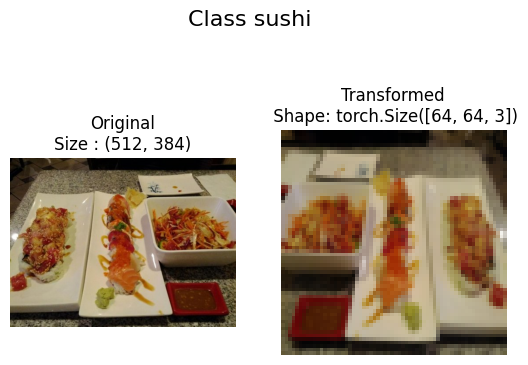

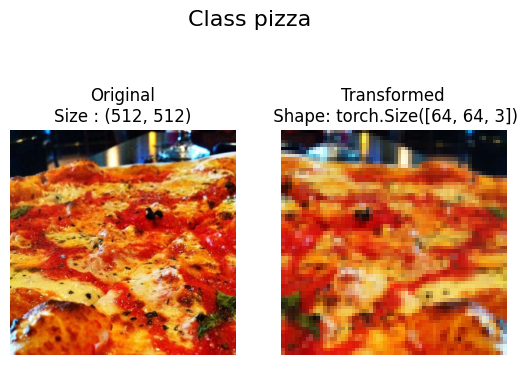

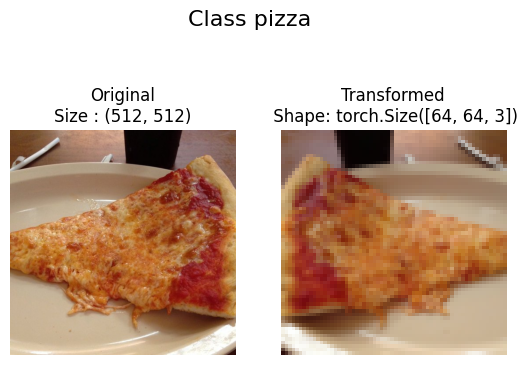

In [14]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  Selects random images from paths of images and loads/transforms them
  then plots the original vs transformed version.
  """

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize : {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # C, H, W => H,W,C
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\n Shape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                       transform=data_transform,
                       n=3,
                       seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classificiation data using `torchvision.datasets.ImageFolder` - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder



In [15]:
# Use ImageFolder to create dataset(s)

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None)    # a transform for the labels

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
#Check the lenght of our dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
# Index on the train data dataset to get a single image and a label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [C,H,W]
Image permute: torch.Size([64, 64, 3]) -> [H, W, C]


Text(0.5, 1.0, 'Pizza')

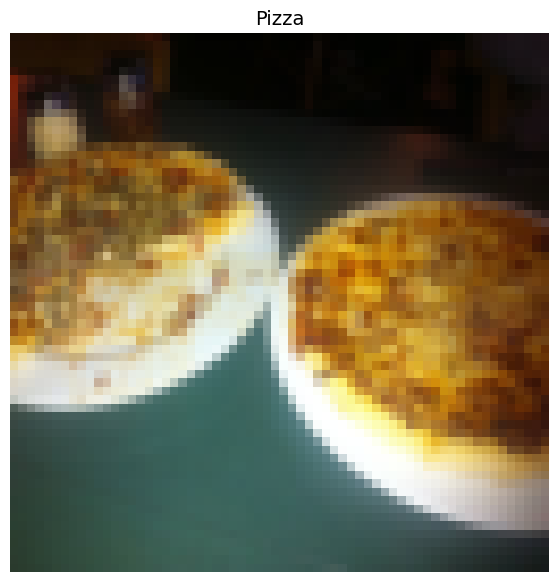

In [19]:
 # Rearrange the order of dimenssions
 img_permute = img.permute(1, 2, 0)

 # Print out different shapes
 print(f"Original shape: {img.shape} -> [C,H,W]")
 print(f"Image permute: {img_permute.shape} -> [H, W, C]")

 # Plot the image
 plt.figure(figsize=(10, 7))
 plt.imshow(img_permute)
 plt.axis("off")
 plt.title("Pizza", fontsize=14)

## 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset` into iterables and we can customize `batch_size` so our model can see `batch_size` image at a time

In [20]:
!nvidia-smi

Fri Sep  1 11:51:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
import os
os.cpu_count()

2

In [22]:
# Turn train and test dataset into `DataLoader`

from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=1, #os.cpu_count()
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=1,
    shuffle=False
)

In [23]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x780921116b30>,
 <torch.utils.data.dataloader.DataLoader at 0x780921116c50>)

In [24]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [25]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you want
print(f"Image shape: {img.shape} -> [batch_size, C, H, W]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, C, H, W]
Label shape: torch.Size([1])


## 5. Option 2 : Loading image data with a custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes dictionary from the Dataset

Pros:
* You can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it dosen't mean it will work
* Using a custom `Dataset` often results in us writting more code, i.e errors or performance issues


All custom dataset in PyTorch often subclass `Dataset`


In [26]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

from typing import Tuple, Dict, List

In [27]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class name using `os.scandir()` to traverse directory (ideally the directory) is in standard image classification format.
2. Raise error if the class names aren't found
3. Turn the class names into a dict and list and return them  


In [28]:
#Setup path for target directory
target_directory = train_dir
print(f"Target Directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [29]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [30]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Find the class folder names in the target directory"""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Could not found any classes in {directory}...Please check file structure.")

  # 3 . Create a directory of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [31]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory,as well has a transfrom if we'd like to transform our data
3. Create serval attributes:
  * paths - paths of our images
  * transform. - the transform we'd like to use
  * classes - a list of target classes
  * class_to_idx - a dict of the target classes mapped to integers label
4. Create a function to `load_images()`, this function will open image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwite the `__getitem()__` method to return a given sample when passed an index

In [32]:
# Write a custom data class
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):

  def __init__(self, target_directory: str, transform=None):
    self.paths = list(Path(target_directory).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(directory=target_directory)

  def __len__(self) -> int:
    """ Return the total number of samples"""
    return len(self.paths)

  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)


  def __getitem__(self, index: int) -> Tuple[torch.Tensor | Image.Image, int]:
    """Return on sample of data and label (X, y)."""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if required
    if self.transform:
      return self.transform(img), class_idx # Return transformed image an label
    return img, class_idx # Return untransformed image and label

In [33]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [34]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(target_directory=train_dir, transform=train_transforms)

test_data_custom = ImageFolderCustom(target_directory=test_dir, transform=test_transforms)

In [35]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7809211145e0>,
 <__main__.ImageFolderCustom at 0x780921117640>)

In [36]:
len(train_data), len(train_data_custom)

(225, 225)

In [37]:
len(test_data), len(test_data_custom)

(75, 75)

In [38]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [39]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [40]:
# Check for equality between original ImageFolder Dataset and ImageCustomFolderDataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to vizualize.
2. To prevent the display getting out of hand let's cap the images to see at 10
3. Set the random seed for reproducibility.
4. Get a list of random sample index from the target dataset.
5. Setup a matplotlib plot
6. Loop through the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [41]:

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, settings to 10 and removing shape display.")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16,8))

  for i, target_sample in enumerate(random_samples_idx):
    target_img, target_label = dataset[target_sample][0], dataset[target_sample][1]

    # Adjust tensor dimension for plotting
    target_img_adjust = target_img.permute(1, 2, 0) # [C, H, W] -> [H, W, C]


    plt.subplot(1, n, i+1)
    plt.imshow(target_img_adjust)
    plt.axis(False)
    if classes:
       title = f"Class: {classes[target_label]}"
       if display_shape:
          title = title + f"\nshape: {target_img_adjust.shape}"
    plt.title(title)


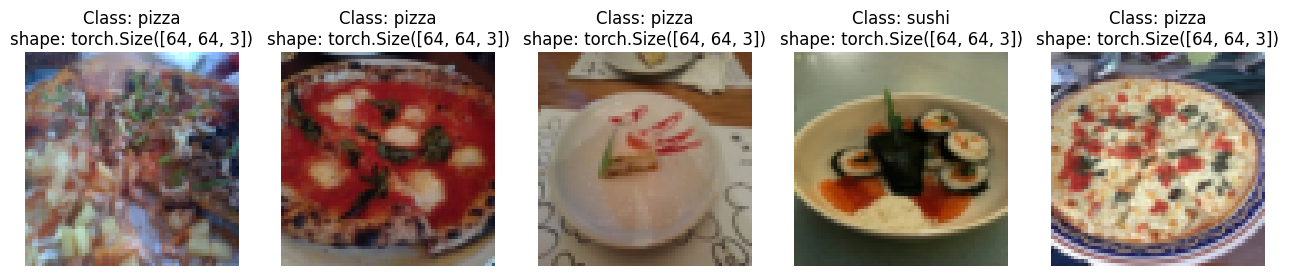

In [42]:
display_random_images(train_data, n=5, classes=train_data_custom.classes, seed=None)

In [45]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7809024ced40>,
 <torch.utils.data.dataloader.DataLoader at 0x7809024cd390>)

In [46]:
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various images transformations (filters) to the training data.

Let's take a look at one particular type of data augmentation to train PyTorch vision moodles to state of the art (SOTA) level.

This practice hopefully results in a model that's more generalizable to unseen data.

Resources:
* Blog Post - https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/


In [48]:
# Let's look at trivial augment - https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])


In [51]:
# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/398345.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3475871.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/930553.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/648055.jpg')]

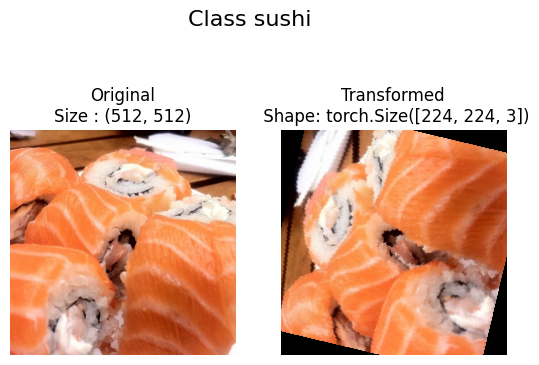

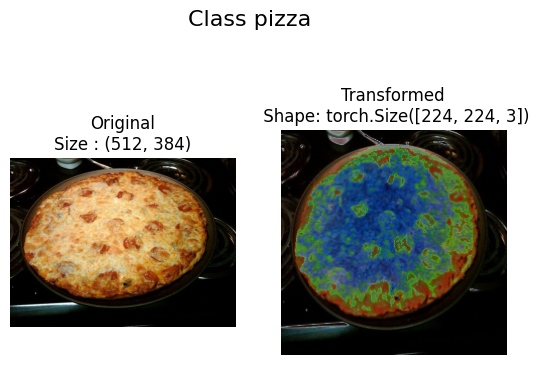

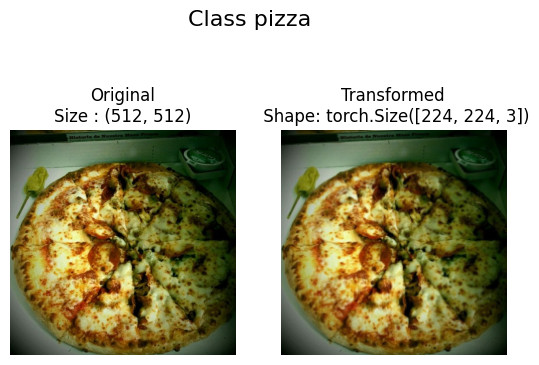

In [57]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

* Tiny VGG - https://poloclub.github.io/cnn-explainer/

Let's replicate the TinyVGG architeture from the previously mentionned cnn-explainer site

### 7.1 Creating transforms and loading data for Model 0

In [60]:
# Creating simple transforms

simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [65]:
# 1. Load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform,
                                         )
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create the dataloader
train_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)